Number of objects after filtering: 11139


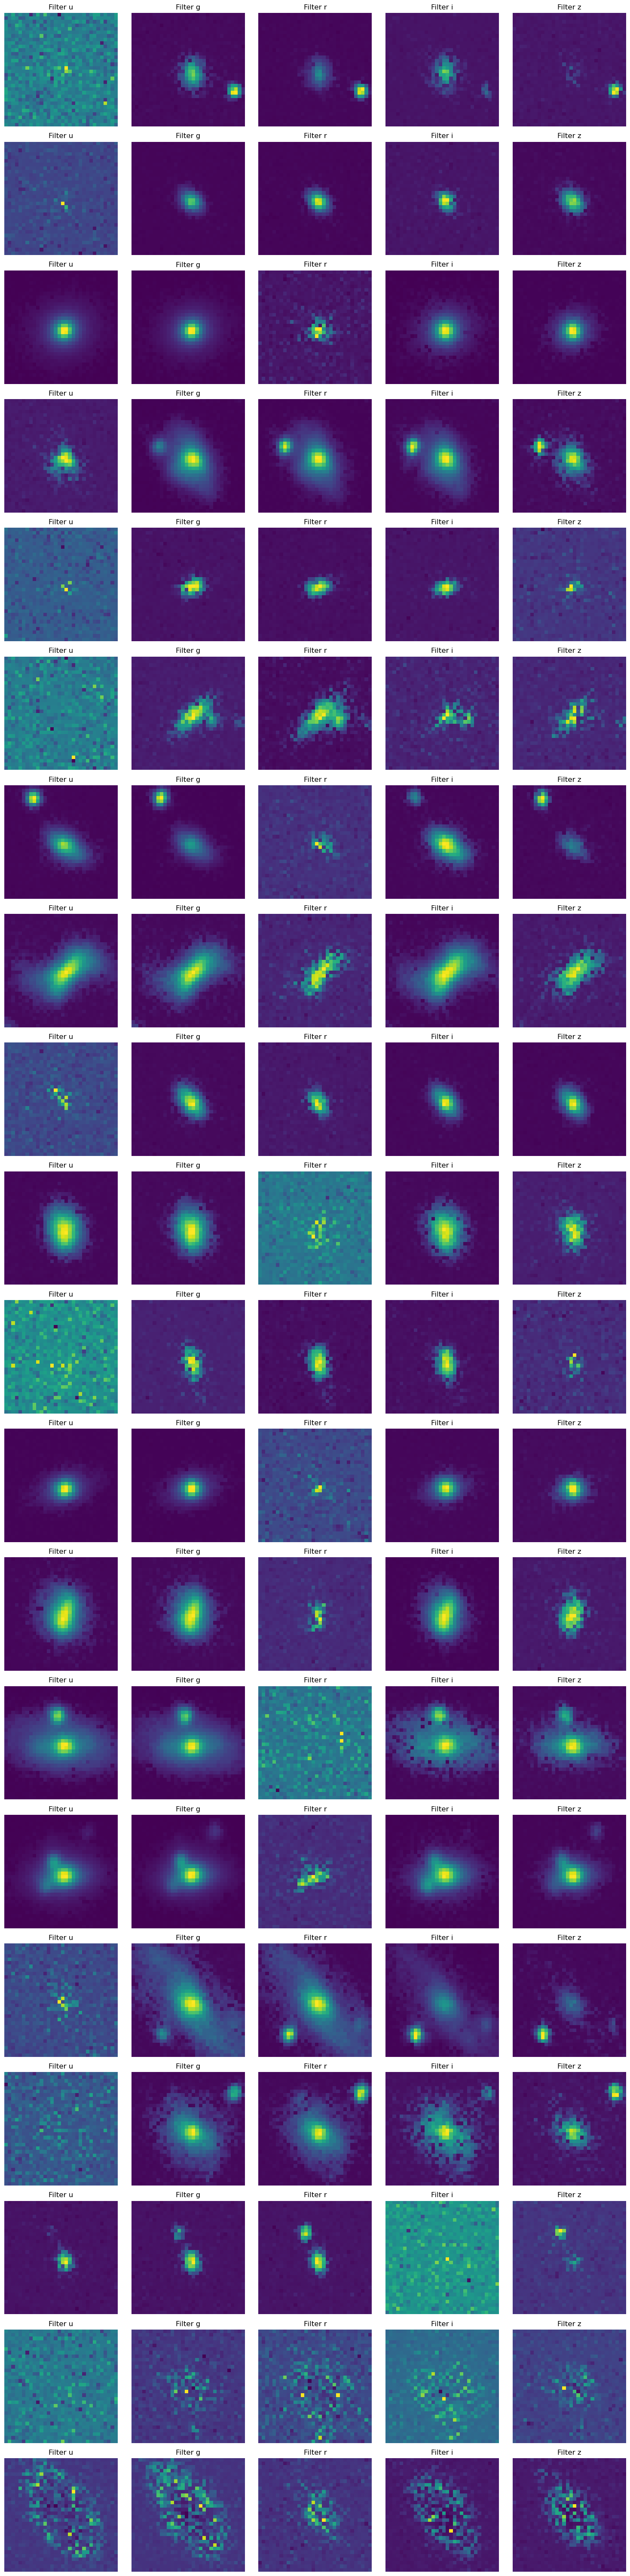

Removed 757 images with multiple objects.


In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy import ndimage

# -------------------------
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------------------
# Data loading and processing
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

labels_simplified = pd.Series(labels).apply(simplify_targettype).values
valid_target_mask = np.isin(labels_simplified, ["GALAXY", "QUASAR", "STAR"])
valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)
final_mask = valid_target_mask & valid_indices
print("Number of objects after filtering:", final_mask.sum())

Y_all = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y_all[final_mask]

filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}

cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    
    if multi_obj_indices:
        display_indices = multi_obj_indices if len(multi_obj_indices) <= max_objects else multi_obj_indices[:max_objects]
        num_rows = len(display_indices)
        fig, axes = plt.subplots(num_rows, 5, figsize=(15, thumbnail_size * num_rows), dpi=100)
        if num_rows == 1:
            axes = axes.reshape(1, -1)
        for row, obj_idx in enumerate(display_indices):
            for col in range(5):
                ax = axes[row, col]
                img_data = all_images_trimmed[0][obj_idx, col, :, :]
                ax.imshow(img_data, vmin=-1, vmax=1)
                ax.set_title(f"Filter {filters[col]}")
                ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No multi-object sources found")
    
    return all_images_trimmed, multi_obj_indices

THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

cropped_images, multi_obj_indices = detect_and_visualize_multiple_objects(
    cropped_images, thresholds=THRESHOLDS_4, crop_sizes=CROP_SIZES_4
)

if multi_obj_indices:
    valid_idx = np.ones(cropped_images[0].shape[0], dtype=bool)
    valid_idx[multi_obj_indices] = False
    cropped_images = [img_arr[valid_idx] for img_arr in cropped_images]
    all_spectra = [spec_arr[valid_idx] for spec_arr in all_spectra]
    Y = Y[valid_idx]
    print(f"Removed {len(multi_obj_indices)} images with multiple objects.")

In [2]:
# -------------------------
# Define image-based models
# Two example image networks:
# 1) ResNet-inspired (https://arxiv.org/abs/1512.03385)
# 2) EfficientNet-inspired (https://arxiv.org/abs/1905.11946)

class ImageCNNModel1(nn.Module):
    def __init__(self, num_channels, output_size=1):
        super(ImageCNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        # Updated fc1: for input 32 channels, image size 32 -> after 2 pools: 32x8x8 = 2048
        self.fc1 = nn.Linear(32 * (CROP_SIZES_4[0] // 4) * (CROP_SIZES_4[0] // 4), 64)
        self.fc2 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImageCNNModel2(nn.Module):
    def __init__(self, num_channels, output_size=1):
        super(ImageCNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.4)
        # For three pools: 32 -> 16 -> 8 -> 4, so flattened: 64*4*4 = 1024
        self.fc1 = nn.Linear(64 * (CROP_SIZES_4[0] // 8) * (CROP_SIZES_4[0] // 8), 128)
        self.fc2 = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class SpectrumMLPModel(nn.Module):
    def __init__(self, input_dim, output_size=1):
        super(SpectrumMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class SpectrumCNNModel(nn.Module):
    def __init__(self, input_channels, input_length, output_size=1):
        super(SpectrumCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)
        # After two poolings, length is reduced by factor of 4:
        self.fc1 = nn.Linear(64 * (input_length // 4), 64)
        self.fc2 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# -------------------------
# Training settings
epochs = 100
patience = 10
learning_rate = 0.0005
batch_size = 64

# Dictionaries to store results
results_image = {}
results_spectrum = {}

In [3]:
# -------------------------
# Train and evaluate image models using cropped_images[0]
# X_img: shape (n_samples, channels, H, W)
X_img = cropped_images[0]
n_samples = X_img.shape[0]

In [4]:
# Loop over each zoom level (for spectra comparison)
for zoom_level in range(4):
    print(f'\nProcessing zoom level {zoom_level} for spectra')
    
    # For images, the input remains fixed (zoom level 0)
    # For spectra, use the corresponding zoom level
    X_spec = all_spectra[zoom_level]
    
    # Split image data for image-based prediction
    X_img_train, X_img_temp, y_img_train, y_img_temp = train_test_split(
        X_img, Y, test_size=0.4, random_state=42, shuffle=True)
    X_img_val, X_img_test, y_img_val, y_img_test = train_test_split(
        X_img_temp, y_img_temp, test_size=0.5, random_state=42, shuffle=True)
    
    # Split spectrum data for spectrum-based prediction
    X_spec_train, X_spec_temp, y_spec_train, y_spec_temp = train_test_split(
        X_spec, Y, test_size=0.4, random_state=42, shuffle=True)
    X_spec_val, X_spec_test, y_spec_val, y_spec_test = train_test_split(
        X_spec_temp, y_spec_temp, test_size=0.5, random_state=42, shuffle=True)

    X_spec_train = np.nan_to_num(X_spec_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_spec_val = np.nan_to_num(X_spec_val, nan=0.0, posinf=0.0, neginf=0.0)
    X_spec_test = np.nan_to_num(X_spec_test, nan=0.0, posinf=0.0, neginf=0.0)
    
    y_spec_train = np.nan_to_num(y_spec_train)
    y_spec_val = np.nan_to_num(y_spec_val)
    y_spec_test = np.nan_to_num(y_spec_test)
    
    # Create DataLoaders for images
    train_loader_img = DataLoader(
        TensorDataset(torch.tensor(X_img_train, dtype=torch.float32), 
                      torch.tensor(y_img_train, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True)
    val_loader_img = DataLoader(
        TensorDataset(torch.tensor(X_img_val, dtype=torch.float32), 
                      torch.tensor(y_img_val, dtype=torch.float32)),
        batch_size=batch_size)
    test_loader_img = DataLoader(
        TensorDataset(torch.tensor(X_img_test, dtype=torch.float32), 
                      torch.tensor(y_img_test, dtype=torch.float32)),
        batch_size=batch_size)
    
    # Create DataLoaders for spectra
    # For the MLP, we flatten the spectrum; for CNN, add a channel dimension.
    X_spec_train_flat = torch.tensor(X_spec_train, dtype=torch.float32)
    X_spec_val_flat = torch.tensor(X_spec_val, dtype=torch.float32)
    X_spec_test_flat = torch.tensor(X_spec_test, dtype=torch.float32)
    
    X_spec_train_cnn = X_spec_train_flat.unsqueeze(1)
    X_spec_val_cnn = X_spec_val_flat.unsqueeze(1)
    X_spec_test_cnn = X_spec_test_flat.unsqueeze(1)
    
    train_loader_spec_mlp = DataLoader(
        TensorDataset(X_spec_train_flat, torch.tensor(y_spec_train, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True)
    val_loader_spec_mlp = DataLoader(
        TensorDataset(X_spec_val_flat, torch.tensor(y_spec_val, dtype=torch.float32)),
        batch_size=batch_size)
    test_loader_spec_mlp = DataLoader(
        TensorDataset(X_spec_test_flat, torch.tensor(y_spec_test, dtype=torch.float32)),
        batch_size=batch_size)
    
    train_loader_spec_cnn = DataLoader(
        TensorDataset(X_spec_train_cnn, torch.tensor(y_spec_train, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True)
    val_loader_spec_cnn = DataLoader(
        TensorDataset(X_spec_val_cnn, torch.tensor(y_spec_val, dtype=torch.float32)),
        batch_size=batch_size)
    test_loader_spec_cnn = DataLoader(
        TensorDataset(X_spec_test_cnn, torch.tensor(y_spec_test, dtype=torch.float32)),
        batch_size=batch_size)
    
    # -------------------------
    # Train image models
    for model_name, model_class in [("ImageCNNModel1", ImageCNNModel1), ("ImageCNNModel2", ImageCNNModel2)]:
        print(f"\nTraining image model {model_name} (zoom level {zoom_level})")
        model = model_class(num_channels=X_img.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        best_val_loss = np.inf
        patience_counter = 0
        best_model_weights = None
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for imgs, targets in train_loader_img:
                optimizer.zero_grad()
                outputs = model(imgs).squeeze()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_train_loss = epoch_loss / len(train_loader_img)
            train_losses.append(avg_train_loss)
            
            model.eval()
            val_loss = np.mean([criterion(model(imgs).squeeze(), targets).item() 
                                for imgs, targets in val_loader_img])
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} for {model_name} (images)")
                    break
        if best_model_weights is not None:
            model.load_state_dict(best_model_weights)
        model.eval()
        preds = []
        targets_list = []
        with torch.no_grad():
            for imgs, targets in test_loader_img:
                outputs = model(imgs).squeeze()
                preds.extend(outputs.numpy())
                targets_list.extend(targets.numpy())
        rmse = np.sqrt(mean_squared_error(targets_list, preds))
        r2 = r2_score(targets_list, preds)
        results_image[(zoom_level, model_name)] = {'RMSE': rmse, 'R2': r2}
        print(f"{model_name} (images) - Zoom {zoom_level} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
    
    # -------------------------
    # Train spectrum models
    # Spectrum MLP
    print(f"\nTraining spectrum model SpectrumMLPModel (zoom level {zoom_level})")
    input_dim_spec = X_spec_train.shape[1]
    model_spec_mlp = SpectrumMLPModel(input_dim=input_dim_spec)
    optimizer = optim.Adam(model_spec_mlp.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    best_val_loss = np.inf
    patience_counter = 0
    best_model_weights = None
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model_spec_mlp.train()
        epoch_loss = 0
        for specs, targets in train_loader_spec_mlp:
            optimizer.zero_grad()
            outputs = model_spec_mlp(specs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader_spec_mlp)
        train_losses.append(avg_train_loss)
        
        model_spec_mlp.eval()
        val_loss = np.mean([criterion(model_spec_mlp(specs).squeeze(), targets).item()
                            for specs, targets in val_loader_spec_mlp])
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model_spec_mlp.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for SpectrumMLPModel")
                break
    if best_model_weights is not None:
        model_spec_mlp.load_state_dict(best_model_weights)
    model_spec_mlp.eval()
    preds = []
    targets_list = []
    with torch.no_grad():
        for specs, targets in test_loader_spec_mlp:
            outputs = model_spec_mlp(specs).squeeze()
            preds.extend(outputs.numpy())
            targets_list.extend(targets.numpy())
    rmse = np.sqrt(mean_squared_error(targets_list, preds))
    r2 = r2_score(targets_list, preds)
    results_spectrum[(zoom_level, "SpectrumMLPModel")] = {'RMSE': rmse, 'R2': r2}
    print(f"SpectrumMLPModel - Zoom {zoom_level} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
    
    # Spectrum CNN
    print(f"\nTraining spectrum model SpectrumCNNModel (zoom level {zoom_level})")
    model_spec_cnn = SpectrumCNNModel(input_channels=1, input_length=X_spec_train.shape[1])
    optimizer = optim.Adam(model_spec_cnn.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    best_val_loss = np.inf
    patience_counter = 0
    best_model_weights = None
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model_spec_cnn.train()
        epoch_loss = 0
        for specs, targets in train_loader_spec_cnn:
            optimizer.zero_grad()
            outputs = model_spec_cnn(specs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader_spec_cnn)
        train_losses.append(avg_train_loss)
        
        model_spec_cnn.eval()
        val_loss = np.mean([criterion(model_spec_cnn(specs).squeeze(), targets).item()
                            for specs, targets in val_loader_spec_cnn])
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model_spec_cnn.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for SpectrumCNNModel")
                break
    if best_model_weights is not None:
        model_spec_cnn.load_state_dict(best_model_weights)
    model_spec_cnn.eval()
    preds = []
    targets_list = []
    with torch.no_grad():
        for specs, targets in test_loader_spec_cnn:
            outputs = model_spec_cnn(specs).squeeze()
            preds.extend(outputs.numpy())
            targets_list.extend(targets.numpy())
    rmse = np.sqrt(mean_squared_error(targets_list, preds))
    r2 = r2_score(targets_list, preds)
    results_spectrum[(zoom_level, "SpectrumCNNModel")] = {'RMSE': rmse, 'R2': r2}
    print(f"SpectrumCNNModel - Zoom {zoom_level} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# Visualization of results

# Convert results to DataFrames for visualization
results_img_df = pd.DataFrame([
    {"Zoom Level": zl, "Model": model, "RMSE": res["RMSE"], "R2": res["R2"]}
    for (zl, model), res in results_image.items()
])


Processing zoom level 0 for spectra

Training image model ImageCNNModel1 (zoom level 0)
Epoch 1: Train Loss = 0.5449, Val Loss = 0.5543
Epoch 2: Train Loss = 0.5264, Val Loss = 0.5438
Epoch 3: Train Loss = 0.5112, Val Loss = 0.5138
Epoch 4: Train Loss = 0.4975, Val Loss = 0.5016
Epoch 5: Train Loss = 0.4862, Val Loss = 0.4811
Epoch 6: Train Loss = 0.4831, Val Loss = 0.4818
Epoch 7: Train Loss = 0.4726, Val Loss = 0.4865
Epoch 8: Train Loss = 0.4741, Val Loss = 0.4811
Epoch 9: Train Loss = 0.4678, Val Loss = 0.4668
Epoch 10: Train Loss = 0.4660, Val Loss = 0.4621
Epoch 11: Train Loss = 0.4576, Val Loss = 0.4559
Epoch 12: Train Loss = 0.4497, Val Loss = 0.4506
Epoch 13: Train Loss = 0.4381, Val Loss = 0.4468
Epoch 14: Train Loss = 0.4362, Val Loss = 0.4326
Epoch 15: Train Loss = 0.4351, Val Loss = 0.4443
Epoch 16: Train Loss = 0.4262, Val Loss = 0.4388
Epoch 17: Train Loss = 0.4303, Val Loss = 0.4245
Epoch 18: Train Loss = 0.4245, Val Loss = 0.4316
Epoch 19: Train Loss = 0.4215, Val Los

Image Models Results:
   Zoom Level           Model      RMSE        R2
0           0  ImageCNNModel1  0.606064  0.291773
1           0  ImageCNNModel2  0.590832  0.326924
2           1  ImageCNNModel1  0.627136  0.241667
3           1  ImageCNNModel2  0.584936  0.340290
4           2  ImageCNNModel1  0.604218  0.296080
5           2  ImageCNNModel2  0.593854  0.320022
6           3  ImageCNNModel1  0.607289  0.288906
7           3  ImageCNNModel2  0.595846  0.315451

Spectrum Models Results:
   Zoom Level             Model      RMSE        R2
0           0  SpectrumMLPModel  0.709378  0.029733
1           0  SpectrumCNNModel  0.720270 -0.000291
2           1  SpectrumMLPModel  0.708783  0.031360
3           1  SpectrumCNNModel  0.720295 -0.000361
4           2  SpectrumMLPModel  0.708960  0.030875
5           2  SpectrumCNNModel  0.718680  0.004120
6           3  SpectrumMLPModel  0.708609  0.031836
7           3  SpectrumCNNModel  0.708789  0.031344


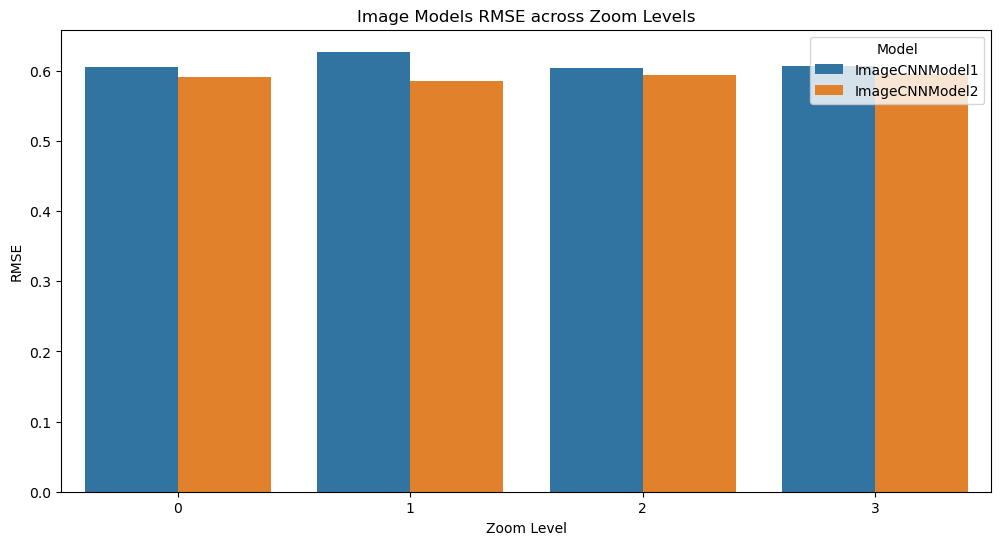

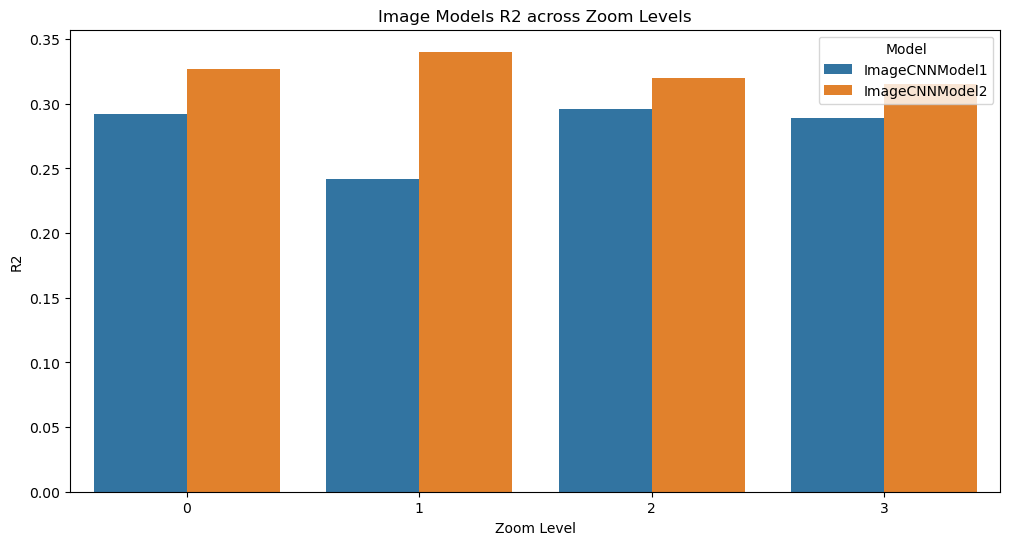

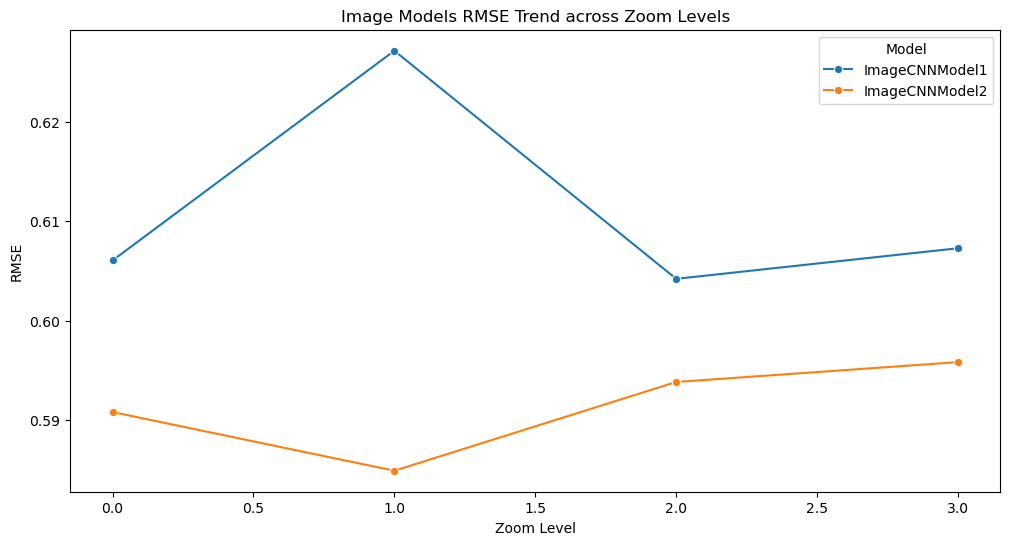

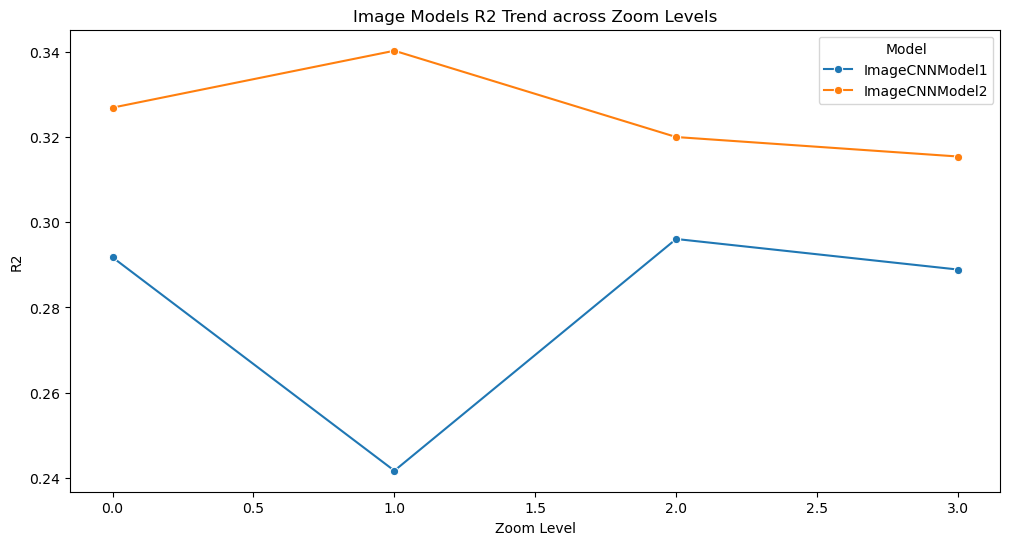

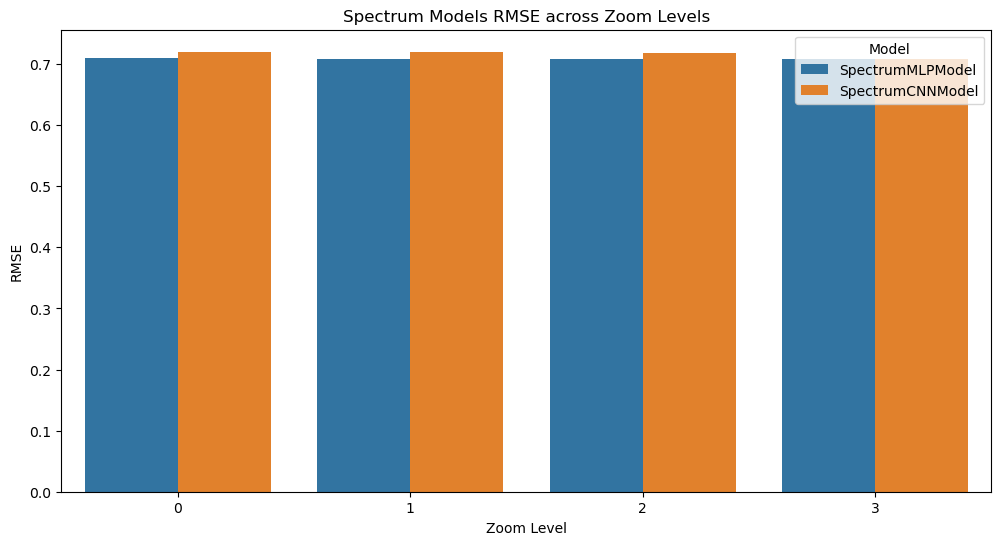

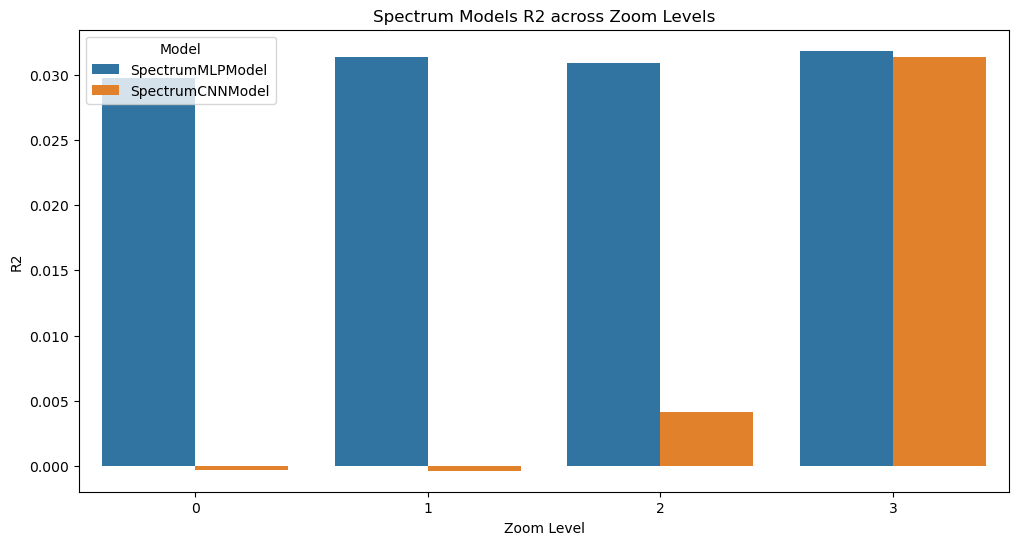

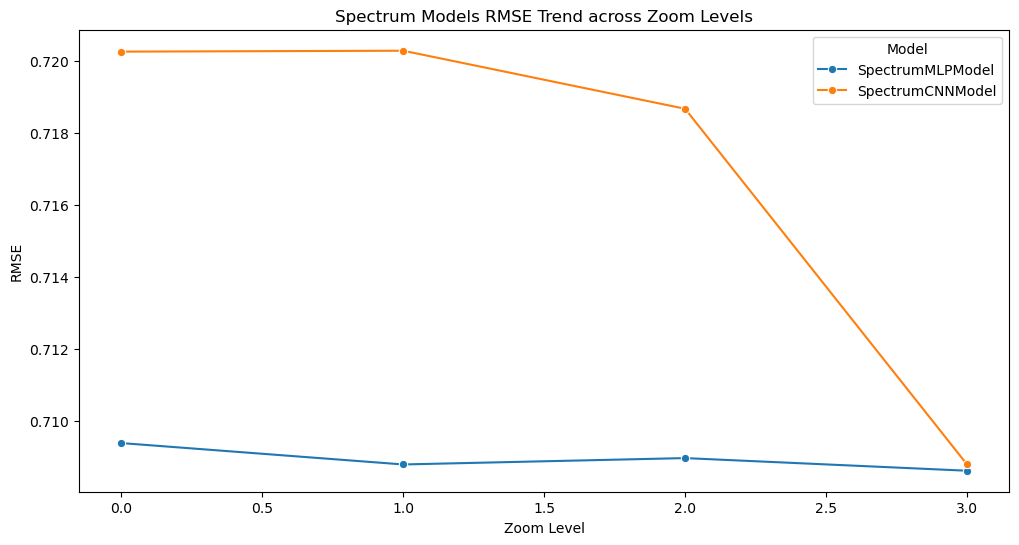

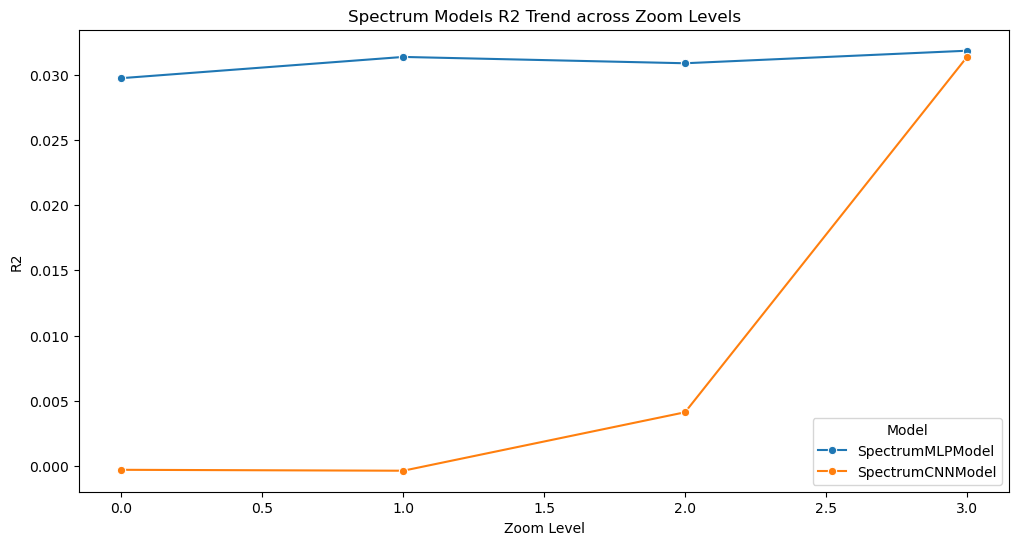

Top 2 image models:
   Zoom Level           Model      RMSE        R2
3           1  ImageCNNModel2  0.584936  0.340290
1           0  ImageCNNModel2  0.590832  0.326924

Top 2 spectrum models:
   Zoom Level             Model      RMSE        R2
6           3  SpectrumMLPModel  0.708609  0.031836
2           1  SpectrumMLPModel  0.708783  0.031360


In [5]:
results_spec_df = pd.DataFrame([
    {"Zoom Level": zl, "Model": model, "RMSE": res["RMSE"], "R2": res["R2"]}
    for (zl, model), res in results_spectrum.items()
])

print("Image Models Results:")
print(results_img_df)
print("\nSpectrum Models Results:")
print(results_spec_df)

# Plot image models results
plt.figure(figsize=(12, 6))
sns.barplot(data=results_img_df, x="Zoom Level", y="RMSE", hue="Model")
plt.title("Image Models RMSE across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_img_df, x="Zoom Level", y="R2", hue="Model")
plt.title("Image Models R2 across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_img_df, x="Zoom Level", y="RMSE", hue="Model", marker="o")
plt.title("Image Models RMSE Trend across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_img_df, x="Zoom Level", y="R2", hue="Model", marker="o")
plt.title("Image Models R2 Trend across Zoom Levels")
plt.show()

# Plot spectrum models results
plt.figure(figsize=(12, 6))
sns.barplot(data=results_spec_df, x="Zoom Level", y="RMSE", hue="Model")
plt.title("Spectrum Models RMSE across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_spec_df, x="Zoom Level", y="R2", hue="Model")
plt.title("Spectrum Models R2 across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_spec_df, x="Zoom Level", y="RMSE", hue="Model", marker="o")
plt.title("Spectrum Models RMSE Trend across Zoom Levels")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_spec_df, x="Zoom Level", y="R2", hue="Model", marker="o")
plt.title("Spectrum Models R2 Trend across Zoom Levels")
plt.show()

# -------------------------
# Final comparison of best models
top2_images = results_img_df.nsmallest(2, 'RMSE')[["Zoom Level", "Model", "RMSE", "R2"]]
top2_spectra = results_spec_df.nsmallest(2, 'RMSE')[["Zoom Level", "Model", "RMSE", "R2"]]

print("Top 2 image models:")
print(top2_images)
print("\nTop 2 spectrum models:")
print(top2_spectra)